In [1]:
## 処理設定

verbose = False
check   = False

### 言語の割合の均等化

balanced = True

### LDA 用

## トピック数

n_topics = 15 # 30は多過ぎる？

## doc, term の設定

doc_type      = 'form'  # 変更不可
doc_attr      = 'sound' # spell か sound の選択
max_doc_size  = 12
##
term_size     = 'character'
term_type     = '1gram'

## skippy n-gram の結合範囲

max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

## ngram を包括的にするかどうか

ngram_is_inclusive = True

### DTM 構築

## term の最低頻度

term_min_freq = 2

## 高頻度 term の濫用指標: 大きくし過ぎないように．0.05 は十分に大きい

term_abuse_threshold = 0.04

max_distance_val: 10


In [2]:
## 言語の選別

##綴り解析で使える言語
## arabic, bengali, chinese, esperanto, english, finnish, french,
## german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, russian, spanish, swahili, turkish

##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili



import re

select_languages = True
#
spell_set0 = "arabic, bengali, chinese, esperato, english, finnish, french, german, greek, \
                          hebrew, hungarian, icelandic, irish, italian, japanese, \
                          russian, spanish, russian, turkish"
#
spell_set1 = "english, french, german, icelandic, irish, spanish, italian, swahili, turkish"
#
spell_set2 = "arabic, bengali, hebrew, english, french, greek, hungarian, icelandic, russian, spanish, turkish"
#
sound_set0 = "arabic, chinese, english, french, german, icelandic, japanese, korean, spanish, swahili"

sound_set1 = "arabic, chinese, french, japanese, korean, spanish, swahili"
##
selected_langs = re.split(r",\s*", sound_set1)

print(f"selected languages: {selected_langs}")

selected languages: ['arabic', 'chinese', 'french', 'japanese', 'korean', 'spanish', 'swahili']


In [3]:
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
from functools import reduce

In [4]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
pp.pprint(target_files)


data-words contains 30 files to process
[PosixPath('data-words/base-sound-Arabic-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Chinese-main-r0-1k-mc-sorted.csv'),
 PosixPath('data-words/base-sound-English-r6e-original.csv'),
 PosixPath('data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv'),
 PosixPath('data-words/base-sound-French-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-French-r0-opendic-s900.csv'),
 PosixPath('data-words/base-sound-German-r1a-original.csv'),
 PosixPath('data-words/base-sound-Icelandic-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Japanese-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Korean-r0-1k-mc-sorted.csv'),
 PosixPath('data-words/base-sound-Spanish-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Swahili-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-Arabic-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-Chinese-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-English-r6e-original.csv'),
 PosixPath('data-words/base-spell-Esperanto-r

In [5]:
import pandas as pd

## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_name_list = "arabic, bengali, chinese, english, esperanto, \
    finnish, french, greek, galician, german, hebrew, hungarian, \
    icelandic, irish, italian, japanese, korean, russian, spanish, swahili, turkish"

langs = re.split(r",\s*", lang_name_list)
lang_settings = { lang : 0 for lang in langs }
print(f"{len(lang_settings.keys())} langs are available")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
21 langs are available
{'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'galician': 0, 'german': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'korean': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'galician': 0, 'german': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'korean': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}


In [6]:
check = False

setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'bengali', 'chinese', 'english', 'esperanto', 'finnish', 'french', 'greek', 'galician', 'german', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'japanese', 'korean', 'russian', 'spanish', 'swahili', 'turkish']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-sound-Chinese-main-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Chinese-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-spell-Greek-r0-1k-mc.csv
reading: data-words/b

In [7]:
## データ統合

raw_df = pd.concat(d_parts)
raw_df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0    kamaː    1      0      1       1        0        0        0          0   
1    ʔanaː    1      0      1       1        0        0        0          0   
2     lahu    1      0      1       1        0        0        0          0   
3      ʔan    1      0      1       1        0        0        0          0   
4     huːa    1      0      1       1        0        0        0          0   
..     ...  ...    ...    ...     ...      ...      ...      ...        ...   
994  burun    1      1      0       0        0        0        0          0   
995  çoğul    1      1      0       0        0        0        0          0   
996   öfke    1      1      0       0        0        0        0          0   
997  iddia    1      1      0       0        0        0        0          0   
998   kıta    1      1      0       0        0        0        0          0   

     finnish  ...  hungarian  icelandic  irish  italian  japanese  korean  \
0          0  ...          0          0      0        0         0       0   
1          0  ...          0          0      0        0         0       0   
2          0  ...          0          0      0        0         0       0   
3          0  ...          0          0      0        0         0       0   
4          0  ...          0          0      0        0         0       0   
..       ...  ...        ...        ...    ...      ...       ...     ...   
994        0  ...          0          0      0        0         0       0   
995        0  ...          0          0      0        0         0       0   
996        0  ...          0          0      0        0         0       0   
997        0  ...          0          0      0        0         0       0   
998        0  ...          0          0      0        0         0       0   

     russian  spanish  swahili  turkish  
0          0        0        0        0  
1          0        0        0        0  
2          0        0        0        0  
3          0        0        0        0  
4          0        0        0        0  
..       ...      ...      ...      ...  
994        0        0        0        1  
995        0        0        0        1  
996        0        0        0        1  
997        0        0        0        1  
998        0        0        0        1  

[33010 rows x 25 columns]

In [8]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0    kamaː    1      0      1       1        0        0        0          0   
1    ʔanaː    1      0      1       1        0        0        0          0   
2     lahu    1      0      1       1        0        0        0          0   
3      ʔan    1      0      1       1        0        0        0          0   
4     huːa    1      0      1       1        0        0        0          0   
..     ...  ...    ...    ...     ...      ...      ...      ...        ...   
994  burun    1      1      0       0        0        0        0          0   
995  çoğul    1      1      0       0        0        0        0          0   
996   öfke    1      1      0       0        0        0        0          0   
997  iddia    1      1      0       0        0        0        0          0   
998   kıta    1      1      0       0        0        0        0          0   

     finnish  ...  icelandic  irish  italian  japanese  korean  russian  \
0          0  ...          0      0        0         0       0        0   
1          0  ...          0      0        0         0       0        0   
2          0  ...          0      0        0         0       0        0   
3          0  ...          0      0        0         0       0        0   
4          0  ...          0      0        0         0       0        0   
..       ...  ...        ...    ...      ...       ...     ...      ...   
994        0  ...          0      0        0         0       0        0   
995        0  ...          0      0        0         0       0        0   
996        0  ...          0      0        0         0       0        0   
997        0  ...          0      0        0         0       0        0   
998        0  ...          0      0        0         0       0        0   

     spanish  swahili  turkish  language  
0          0        0        0    arabic  
1          0        0        0    arabic  
2          0        0        0    arabic  
3          0        0        0    arabic  
4          0        0        0    arabic  
..       ...      ...      ...       ...  
994        0        0        1   turkish  
995        0        0        1   turkish  
996        0        0        1   turkish  
997        0        0        1   turkish  
998        0        0        1   turkish  

[33010 rows x 26 columns]

In [9]:
## 文字数の列を追加

raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0    kamaː    1      0      1       1        0        0        0          0   
1    ʔanaː    1      0      1       1        0        0        0          0   
2     lahu    1      0      1       1        0        0        0          0   
3      ʔan    1      0      1       1        0        0        0          0   
4     huːa    1      0      1       1        0        0        0          0   
..     ...  ...    ...    ...     ...      ...      ...      ...        ...   
994  burun    1      1      0       0        0        0        0          0   
995  çoğul    1      1      0       0        0        0        0          0   
996   öfke    1      1      0       0        0        0        0          0   
997  iddia    1      1      0       0        0        0        0          0   
998   kıta    1      1      0       0        0        0        0          0   

     finnish  ...  irish  italian  japanese  korean  russian  spanish  \
0          0  ...      0        0         0       0        0        0   
1          0  ...      0        0         0       0        0        0   
2          0  ...      0        0         0       0        0        0   
3          0  ...      0        0         0       0        0        0   
4          0  ...      0        0         0       0        0        0   
..       ...  ...    ...      ...       ...     ...      ...      ...   
994        0  ...      0        0         0       0        0        0   
995        0  ...      0        0         0       0        0        0   
996        0  ...      0        0         0       0        0        0   
997        0  ...      0        0         0       0        0        0   
998        0  ...      0        0         0       0        0        0   

     swahili  turkish  language  size  
0          0        0    arabic     5  
1          0        0    arabic     5  
2          0        0    arabic     4  
3          0        0    arabic     3  
4          0        0    arabic     4  
..       ...      ...       ...   ...  
994        0        1   turkish     5  
995        0        1   turkish     5  
996        0        1   turkish     4  
997        0        1   turkish     5  
998        0        1   turkish     4  

[33010 rows x 27 columns]

In [10]:
## 解析データの型指定

print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: sound


form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0     kamaː    1      0      1       1        0        0        0          0   
1     ʔanaː    1      0      1       1        0        0        0          0   
2      lahu    1      0      1       1        0        0        0          0   
3       ʔan    1      0      1       1        0        0        0          0   
4      huːa    1      0      1       1        0        0        0          0   
..      ...  ...    ...    ...     ...      ...      ...      ...        ...   
878     pua    1      0      1       0        0        0        0          0   
879   wiᵑgi    1      0      1       0        0        0        0          0   
880  hasiɾa    1      0      1       0        0        0        0          0   
881   maɗai    1      0      1       0        0        0        0          0   
882    ɓaɾa    1      0      1       0        0        0        0          0   

     finnish  ...  irish  italian  japanese  korean  russian  spanish  \
0          0  ...      0        0         0       0        0        0   
1          0  ...      0        0         0       0        0        0   
2          0  ...      0        0         0       0        0        0   
3          0  ...      0        0         0       0        0        0   
4          0  ...      0        0         0       0        0        0   
..       ...  ...    ...      ...       ...     ...      ...      ...   
878        0  ...      0        0         0       0        0        0   
879        0  ...      0        0         0       0        0        0   
880        0  ...      0        0         0       0        0        0   
881        0  ...      0        0         0       0        0        0   
882        0  ...      0        0         0       0        0        0   

     swahili  turkish  language  size  
0          0        0    arabic     5  
1          0        0    arabic     5  
2          0        0    arabic     4  
3          0        0    arabic     3  
4          0        0    arabic     4  
..       ...      ...       ...   ...  
878        1        0   swahili     3  
879        1        0   swahili     5  
880        1        0   swahili     6  
881        1        0   swahili     5  
882        1        0   swahili     4  

[12688 rows x 27 columns]

In [11]:
## 言語の選別

if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0     kamaː    1      0      1       1        0        0        0          0   
1     ʔanaː    1      0      1       1        0        0        0          0   
2      lahu    1      0      1       1        0        0        0          0   
3       ʔan    1      0      1       1        0        0        0          0   
4      huːa    1      0      1       1        0        0        0          0   
..      ...  ...    ...    ...     ...      ...      ...      ...        ...   
878     pua    1      0      1       0        0        0        0          0   
879   wiᵑgi    1      0      1       0        0        0        0          0   
880  hasiɾa    1      0      1       0        0        0        0          0   
881   maɗai    1      0      1       0        0        0        0          0   
882    ɓaɾa    1      0      1       0        0        0        0          0   

     finnish  ...  irish  italian  japanese  korean  russian  spanish  \
0          0  ...      0        0         0       0        0        0   
1          0  ...      0        0         0       0        0        0   
2          0  ...      0        0         0       0        0        0   
3          0  ...      0        0         0       0        0        0   
4          0  ...      0        0         0       0        0        0   
..       ...  ...    ...      ...       ...     ...      ...      ...   
878        0  ...      0        0         0       0        0        0   
879        0  ...      0        0         0       0        0        0   
880        0  ...      0        0         0       0        0        0   
881        0  ...      0        0         0       0        0        0   
882        0  ...      0        0         0       0        0        0   

     swahili  turkish  language  size  
0          0        0    arabic     5  
1          0        0    arabic     5  
2          0        0    arabic     4  
3          0        0    arabic     3  
4          0        0    arabic     4  
..       ...      ...       ...   ...  
878        1        0   swahili     3  
879        1        0   swahili     5  
880        1        0   swahili     6  
881        1        0   swahili     5  
882        1        0   swahili     4  

[5992 rows x 27 columns]

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_6096/1088473461.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


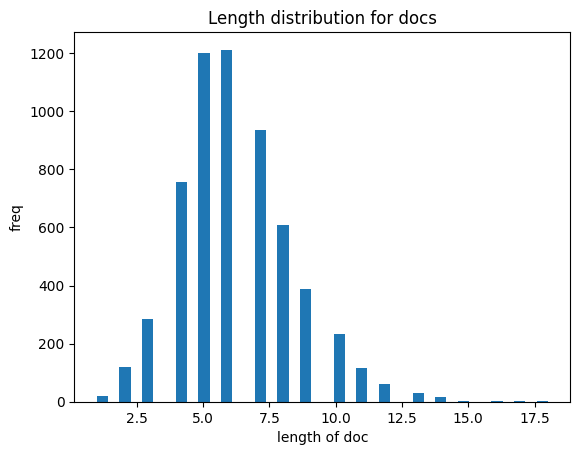

In [12]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

In [13]:
## 長さで濾過

print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] < max_doc_size]
filtered_size = len(raw_df)
print(f"{original_size - filtered_size} cases removed")

max doc size: 12
116 cases removed


In [14]:
## 結果の検査 1

for type in types:
    print(raw_df[type].value_counts())

spell
0    5876
Name: count, dtype: int64
sound
1    5876
Name: count, dtype: int64


In [15]:
## 結果の検査 2

for lang in langs:
    print(raw_df[lang].value_counts())

arabic
0    5152
1     724
Name: count, dtype: int64
bengali
0    5876
Name: count, dtype: int64
chinese
0    5052
1     824
Name: count, dtype: int64
english
0    5876
Name: count, dtype: int64
esperanto
0    5876
Name: count, dtype: int64
finnish
0    5876
Name: count, dtype: int64
french
0    4917
1     959
Name: count, dtype: int64
greek
0    5876
Name: count, dtype: int64
galician
0    5876
Name: count, dtype: int64
german
0    5876
Name: count, dtype: int64
hebrew
0    5876
Name: count, dtype: int64
hungarian
0    5876
Name: count, dtype: int64
icelandic
0    5876
Name: count, dtype: int64
irish
0    5876
Name: count, dtype: int64
italian
0    5876
Name: count, dtype: int64
japanese
0    5058
1     818
Name: count, dtype: int64
korean
0    5155
1     721
Name: count, dtype: int64
russian
0    5876
Name: count, dtype: int64
spanish
0    4927
1     949
Name: count, dtype: int64
swahili
0    4995
1     881
Name: count, dtype: int64
turkish
0    5876
Name: count, dtype: int64


In [16]:
## 統合: 割合補正を適用

eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
raw_df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
0     kamaː    1      0      1       1        0        0        0          0   
1     ʔanaː    1      0      1       1        0        0        0          0   
2      lahu    1      0      1       1        0        0        0          0   
3       ʔan    1      0      1       1        0        0        0          0   
4      huːa    1      0      1       1        0        0        0          0   
..      ...  ...    ...    ...     ...      ...      ...      ...        ...   
878     pua    1      0      1       0        0        0        0          0   
879   wiᵑgi    1      0      1       0        0        0        0          0   
880  hasiɾa    1      0      1       0        0        0        0          0   
881   maɗai    1      0      1       0        0        0        0          0   
882    ɓaɾa    1      0      1       0        0        0        0          0   

     finnish  ...  irish  italian  japanese  korean  russian  spanish  \
0          0  ...      0        0         0       0        0        0   
1          0  ...      0        0         0       0        0        0   
2          0  ...      0        0         0       0        0        0   
3          0  ...      0        0         0       0        0        0   
4          0  ...      0        0         0       0        0        0   
..       ...  ...    ...      ...       ...     ...      ...      ...   
878        0  ...      0        0         0       0        0        0   
879        0  ...      0        0         0       0        0        0   
880        0  ...      0        0         0       0        0        0   
881        0  ...      0        0         0       0        0        0   
882        0  ...      0        0         0       0        0        0   

     swahili  turkish  language  size  
0          0        0    arabic     5  
1          0        0    arabic     5  
2          0        0    arabic     4  
3          0        0    arabic     3  
4          0        0    arabic     4  
..       ...      ...       ...   ...  
878        1        0   swahili     3  
879        1        0   swahili     5  
880        1        0   swahili     6  
881        1        0   swahili     5  
882        1        0   swahili     4  

[5876 rows x 27 columns]

In [17]:
## 結果の検査 3

for lang in langs:
    print(raw_df[lang].value_counts())

arabic
0    5152
1     724
Name: count, dtype: int64
bengali
0    5876
Name: count, dtype: int64
chinese
0    5052
1     824
Name: count, dtype: int64
english
0    5876
Name: count, dtype: int64
esperanto
0    5876
Name: count, dtype: int64
finnish
0    5876
Name: count, dtype: int64
french
0    4917
1     959
Name: count, dtype: int64
greek
0    5876
Name: count, dtype: int64
galician
0    5876
Name: count, dtype: int64
german
0    5876
Name: count, dtype: int64
hebrew
0    5876
Name: count, dtype: int64
hungarian
0    5876
Name: count, dtype: int64
icelandic
0    5876
Name: count, dtype: int64
irish
0    5876
Name: count, dtype: int64
italian
0    5876
Name: count, dtype: int64
japanese
0    5058
1     818
Name: count, dtype: int64
korean
0    5155
1     721
Name: count, dtype: int64
russian
0    5876
Name: count, dtype: int64
spanish
0    4927
1     949
Name: count, dtype: int64
swahili
0    4995
1     881
Name: count, dtype: int64
turkish
0    5876
Name: count, dtype: int64


# 解析

In [18]:
## 順序のランダマイズし，基本データを決定

import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

In [19]:
## ngram の追加

import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

## 1gram 列の追加
#sep = r""
#unigrams = [ list(filter(lambda x: len(x) > 0, y)) for y in [ re.split(sep, z) for z in bases ] ]
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
665    ʈʂɚ˥˥    1      0      1       0        0        1        0          0   
109   manaħa    1      0      1       1        0        0        0          0   
785     kʁɔʃ    1      0      1       0        0        0        0          0   
526   midoɾɯ    1      0      1       0        0        0        0          0   
218   kɾuθaɾ  1.0      0      1       0        0        0        0          0   
..       ...  ...    ...    ...     ...      ...      ...      ...        ...   
752    umana  1.0      0      1       0        0        0        0          0   
455     kabe    1      0      1       0        0        0        0          0   
680   ʈʂʰa˥˩    1      0      1       0        0        1        0          0   
809   koɾamɯ    1      0      1       0        0        0        0          0   
105  insʰa̠ŋ    1      0      1       0        0        0        0          0   

     finnish  ...  italian  japanese  korean  russian  spanish  swahili  \
665        0  ...        0         0       0        0        0        0   
109        0  ...        0         0       0        0        0        0   
785        0  ...        0         0       0        0        0        0   
526        0  ...        0         1       0        0        0        0   
218        0  ...        0         0       0        0        1        0   
..       ...  ...      ...       ...     ...      ...      ...      ...   
752        0  ...        0         0       0        0        1        0   
455        0  ...        0         1       0        0        0        0   
680        0  ...        0         0       0        0        0        0   
809        0  ...        0         1       0        0        0        0   
105        0  ...        0         0       1        0        0        0   

     turkish  language  size                  1gram  
665        0   chinese     5        [ʈ, ʂ, ɚ, ˥, ˥]  
109        0    arabic     6     [m, a, n, a, ħ, a]  
785        0    french     4           [k, ʁ, ɔ, ʃ]  
526        0  japanese     6     [m, i, d, o, ɾ, ɯ]  
218        0   spanish     6     [k, ɾ, u, θ, a, ɾ]  
..       ...       ...   ...                    ...  
752        0   spanish     5        [u, m, a, n, a]  
455        0  japanese     4           [k, a, b, e]  
680        0   chinese     6     [ʈ, ʂ, ʰ, a, ˥, ˩]  
809        0  japanese     6     [k, o, ɾ, a, m, ɯ]  
105        0    korean     7  [i, n, s, ʰ, a, ̠, ŋ]  

[5876 rows x 28 columns]

In [20]:
## 2gram列の追加

bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]

if verbose:
    print(random.sample(bigrams, 3))

In [21]:
df['2gram'] = bigrams
if verbose:
    df

In [22]:
## 3gram列の追加

trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]

if verbose:
    print(random.sample(trigrams, 3))

In [23]:
df['3gram'] = trigrams
if verbose:
    df

In [24]:
## skippy 2grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_2grams = [ ngrams_skippy.generate_skippy_bigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [25]:
## skippy 2gram 列の追加

df['skippy2gram'] = skippy_2grams
df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
665    ʈʂɚ˥˥    1      0      1       0        0        1        0          0   
109   manaħa    1      0      1       1        0        0        0          0   
785     kʁɔʃ    1      0      1       0        0        0        0          0   
526   midoɾɯ    1      0      1       0        0        0        0          0   
218   kɾuθaɾ  1.0      0      1       0        0        0        0          0   
..       ...  ...    ...    ...     ...      ...      ...      ...        ...   
752    umana  1.0      0      1       0        0        0        0          0   
455     kabe    1      0      1       0        0        0        0          0   
680   ʈʂʰa˥˩    1      0      1       0        0        1        0          0   
809   koɾamɯ    1      0      1       0        0        0        0          0   
105  insʰa̠ŋ    1      0      1       0        0        0        0          0   

     finnish  ...  russian  spanish  swahili  turkish  language  size  \
665        0  ...        0        0        0        0   chinese     5   
109        0  ...        0        0        0        0    arabic     6   
785        0  ...        0        0        0        0    french     4   
526        0  ...        0        0        0        0  japanese     6   
218        0  ...        0        1        0        0   spanish     6   
..       ...  ...      ...      ...      ...      ...       ...   ...   
752        0  ...        0        1        0        0   spanish     5   
455        0  ...        0        0        0        0  japanese     4   
680        0  ...        0        0        0        0   chinese     6   
809        0  ...        0        0        0        0  japanese     6   
105        0  ...        0        0        0        0    korean     7   

                     1gram                                          2gram  \
665        [ʈ, ʂ, ɚ, ˥, ˥]                [ʈʂ, ʂɚ, ɚ˥, ˥˥, ʈ, ʂ, ɚ, ˥, ˥]   
109     [m, a, n, a, ħ, a]         [ma, an, na, aħ, ħa, m, a, n, a, ħ, a]   
785           [k, ʁ, ɔ, ʃ]                       [kʁ, ʁɔ, ɔʃ, k, ʁ, ɔ, ʃ]   
526     [m, i, d, o, ɾ, ɯ]         [mi, id, do, oɾ, ɾɯ, m, i, d, o, ɾ, ɯ]   
218     [k, ɾ, u, θ, a, ɾ]         [kɾ, ɾu, uθ, θa, aɾ, k, ɾ, u, θ, a, ɾ]   
..                     ...                                            ...   
752        [u, m, a, n, a]                [um, ma, an, na, u, m, a, n, a]   
455           [k, a, b, e]                       [ka, ab, be, k, a, b, e]   
680     [ʈ, ʂ, ʰ, a, ˥, ˩]         [ʈʂ, ʂʰ, ʰa, a˥, ˥˩, ʈ, ʂ, ʰ, a, ˥, ˩]   
809     [k, o, ɾ, a, m, ɯ]         [ko, oɾ, ɾa, am, mɯ, k, o, ɾ, a, m, ɯ]   
105  [i, n, s, ʰ, a, ̠, ŋ]  [in, ns, sʰ, ʰa, a̠, ̠ŋ, i, n, s, ʰ, a, ̠, ŋ]   

                                                 3gram  \
665     [ʈʂɚ, ʂɚ˥, ɚ˥˥, ʈʂ, ʂɚ, ɚ˥, ˥˥, ʈ, ʂ, ɚ, ˥, ˥]   
109  [man, ana, naħ, aħa, ma, an, na, aħ, ħa, m, a,...   
785                 [kʁɔ, ʁɔʃ, kʁ, ʁɔ, ɔʃ, k, ʁ, ɔ, ʃ]   
526  [mid, ido, doɾ, oɾɯ, mi, id, do, oɾ, ɾɯ, m, i,...   
218  [kɾu, ɾuθ, uθa, θaɾ, kɾ, ɾu, uθ, θa, aɾ, k, ɾ,...   
..                                                 ...   
752     [uma, man, ana, um, ma, an, na, u, m, a, n, a]   
455                 [kab, abe, ka, ab, be, k, a, b, e]   
680  [ʈʂʰ, ʂʰa, ʰa˥, a˥˩, ʈʂ, ʂʰ, ʰa, a˥, ˥˩, ʈ, ʂ,...   
809  [koɾ, oɾa, ɾam, amɯ, ko, oɾ, ɾa, am, mɯ, k, o,...   
105  [ins, nsʰ, sʰa, ʰa̠, a̠ŋ, in, ns, sʰ, ʰa, a̠, ...   

                                           skippy2gram  
665  [ʈʂ, ʈ…ɚ, ʈ…˥, ʂɚ, ʂ…˥, ɚ˥, ɚ…˥, ˥˥, ʈ, ʂ, ɚ, ...  
109  [ma, m…n, m…a, m…ħ, an, a…a, a…ħ, na, n…ħ, n…a...  
785            [kʁ, k…ɔ, k…ʃ, ʁɔ, ʁ…ʃ, ɔʃ, k, ʁ, ɔ, ʃ]  
526  [mi, m…d, m…o, m…ɾ, m…ɯ, id, i…o, i…ɾ, i…ɯ, do...  
218  [kɾ, k…u, k…θ, k…a, k…ɾ, ɾu, ɾ…θ, ɾ…a, ɾ…ɾ, uθ...  
..                                                 ...  
752  [um, u…a, u…n, ma, m…n, m…a, an, a…a, na, u, m...  
455            [ka, k…b, k…e, ab, a…e, be, k, a, b, e]  
680  [ʈʂ, ʈ…ʰ, ʈ…a, ʈ…˥

In [26]:
## skippy 3grams の生成

#import sys
#sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_3grams = [ ngrams_skippy.generate_skippy_trigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [27]:
## skippy 3gram 列の追加

df['skippy3gram'] = skippy_3grams
df

form freq  spell  sound  arabic  bengali  chinese  english  esperanto  \
665    ʈʂɚ˥˥    1      0      1       0        0        1        0          0   
109   manaħa    1      0      1       1        0        0        0          0   
785     kʁɔʃ    1      0      1       0        0        0        0          0   
526   midoɾɯ    1      0      1       0        0        0        0          0   
218   kɾuθaɾ  1.0      0      1       0        0        0        0          0   
..       ...  ...    ...    ...     ...      ...      ...      ...        ...   
752    umana  1.0      0      1       0        0        0        0          0   
455     kabe    1      0      1       0        0        0        0          0   
680   ʈʂʰa˥˩    1      0      1       0        0        1        0          0   
809   koɾamɯ    1      0      1       0        0        0        0          0   
105  insʰa̠ŋ    1      0      1       0        0        0        0          0   

     finnish  ...  spanish  swahili  turkish  language  size  \
665        0  ...        0        0        0   chinese     5   
109        0  ...        0        0        0    arabic     6   
785        0  ...        0        0        0    french     4   
526        0  ...        0        0        0  japanese     6   
218        0  ...        1        0        0   spanish     6   
..       ...  ...      ...      ...      ...       ...   ...   
752        0  ...        1        0        0   spanish     5   
455        0  ...        0        0        0  japanese     4   
680        0  ...        0        0        0   chinese     6   
809        0  ...        0        0        0  japanese     6   
105        0  ...        0        0        0    korean     7   

                     1gram                                          2gram  \
665        [ʈ, ʂ, ɚ, ˥, ˥]                [ʈʂ, ʂɚ, ɚ˥, ˥˥, ʈ, ʂ, ɚ, ˥, ˥]   
109     [m, a, n, a, ħ, a]         [ma, an, na, aħ, ħa, m, a, n, a, ħ, a]   
785           [k, ʁ, ɔ, ʃ]                       [kʁ, ʁɔ, ɔʃ, k, ʁ, ɔ, ʃ]   
526     [m, i, d, o, ɾ, ɯ]         [mi, id, do, oɾ, ɾɯ, m, i, d, o, ɾ, ɯ]   
218     [k, ɾ, u, θ, a, ɾ]         [kɾ, ɾu, uθ, θa, aɾ, k, ɾ, u, θ, a, ɾ]   
..                     ...                                            ...   
752        [u, m, a, n, a]                [um, ma, an, na, u, m, a, n, a]   
455           [k, a, b, e]                       [ka, ab, be, k, a, b, e]   
680     [ʈ, ʂ, ʰ, a, ˥, ˩]         [ʈʂ, ʂʰ, ʰa, a˥, ˥˩, ʈ, ʂ, ʰ, a, ˥, ˩]   
809     [k, o, ɾ, a, m, ɯ]         [ko, oɾ, ɾa, am, mɯ, k, o, ɾ, a, m, ɯ]   
105  [i, n, s, ʰ, a, ̠, ŋ]  [in, ns, sʰ, ʰa, a̠, ̠ŋ, i, n, s, ʰ, a, ̠, ŋ]   

                                                 3gram  \
665     [ʈʂɚ, ʂɚ˥, ɚ˥˥, ʈʂ, ʂɚ, ɚ˥, ˥˥, ʈ, ʂ, ɚ, ˥, ˥]   
109  [man, ana, naħ, aħa, ma, an, na, aħ, ħa, m, a,...   
785                 [kʁɔ, ʁɔʃ, kʁ, ʁɔ, ɔʃ, k, ʁ, ɔ, ʃ]   
526  [mid, ido, doɾ, oɾɯ, mi, id, do, oɾ, ɾɯ, m, i,...   
218  [kɾu, ɾuθ, uθa, θaɾ, kɾ, ɾu, uθ, θa, aɾ, k, ɾ,...   
..                                                 ...   
752     [uma, man, ana, um, ma, an, na, u, m, a, n, a]   
455                 [kab, abe, ka, ab, be, k, a, b, e]   
680  [ʈʂʰ, ʂʰa, ʰa˥, a˥˩, ʈʂ, ʂʰ, ʰa, a˥, ˥˩, ʈ, ʂ,...   
809  [koɾ, oɾa, ɾam, amɯ, ko, oɾ, ɾa, am, mɯ, k, o,...   
105  [ins, nsʰ, sʰa, ʰa̠, a̠ŋ, in, ns, sʰ, ʰa, a̠, ...   

                                           skippy2gram  \
665  [ʈʂ, ʈ…ɚ, ʈ…˥, ʂɚ, ʂ…˥, ɚ˥, ɚ…˥, ˥˥, ʈ, ʂ, ɚ, ...   
109  [ma, m…n, m…a, m…ħ, an, a…a, a…ħ, na, n…ħ, n…a...   
785            [kʁ, k…ɔ, k…ʃ, ʁɔ, ʁ…ʃ, ɔʃ, k, ʁ, ɔ, ʃ]   
526  [mi, m…d, m…o, m…ɾ, m…ɯ, id, i…o, i…ɾ, i…ɯ, do...   
218  [kɾ, k…u, k…θ, k…a, k…ɾ, ɾu, ɾ…θ, ɾ…a, ɾ…ɾ, uθ...   
..                                                 ...   
752  [um, u…a, u…n, ma, m…n, m…a, an, a…a, na, u, m...   
455            [ka, k…b, k…e, ab, a…e, be, k, a, b, e]   
680  [ʈʂ, ʈ…ʰ, ʈ…a, ʈ…˥, ʈ…˩, ʂʰ, ʂ…a, ʂ…˥, ʂ…˩, ʰa...   
809  [ko, k…ɾ, k…a, k…m, k…ɯ, oɾ, o…a, o…m, o…ɯ, ɾa...   
105  [

In [28]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary

bots = df[term_type]
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<96 unique tokens: ['ɚ', 'ʂ', 'ʈ', '˥', 'a']...>


In [29]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.04
Dictionary<61 unique tokens: ['ɚ', 'ʂ', 'ʈ', 'ħ', 'ʃ']...>


In [30]:
## Corpus (gensim の用語では corpus) の構築

corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 5876


In [31]:
## LDA モデルの構築

from gensim.models import LdaModel
#from tqdm import tqdm

## LDAモデル
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15
LdaModel<num_terms=96, num_topics=15, decay=0.5, chunksize=2000>


In [32]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示

import pandas as pd

n_terms = 40 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5 topic 6 topic 7 topic 8 topic 9  \
0        ɯ       o       o       ˥       a       a       i       t       j   
1        i       t       k       ˩       m       l       a       e       ˥   
2        k       i       n       t       u       ː       p       a       ˩   
3        s       a       m       ˨       t       i       ɛ       s       i   
4        a       ɾ       a       ˦       k       q       t       i       o   
5        ɾ       ɯ       i       ˧       s       n       o       o       ɕ   
6        t       s       ʌ       i       ɾ       w       s       n       p   
7        o       m       ̹       ʰ       i       f       ̝       ɕ       a   
8        e       ː       t       ʊ       r       s       ɓ       d       ɛ   
9        ɕ       u       ɾ       ɕ       h       m       ᵐ       ̞       ɑ   
10       ː       n       j       ŋ       e       d       ʃ       ͡       ʊ   
11       ɴ       ɕ       ̠       e       o       ʔ       l       ʰ       n   
12       b       p       ̞       ɪ       l       r       n       j       u   
13       n       j       u       ɤ       ʃ       k       ɲ       u       t   
14       d       g       d       d       θ       ħ       ̚       ̠       x   
15       ɸ       e       ɯ       n       ˥       h       k       m       ŋ   
16       ˥       ɴ       ʰ       ɑ       ɴ       ˤ       ʰ       ŋ       ˧   
17       m       h       ˈ       m       ɓ       ɔ       e       l       f   
18       u       ʰ       ͡       k       ʎ       ʒ       ɾ       ɾ       l   
19       ɥ       d       p       a       ʐ       x       u       ɭ       ɾ   
20       z       k       ŋ       ʂ       f       b       j       p       ø   
21       g       ̠       e       ɴ       ˤ       ɣ       m       ʑ       b   
22       ʰ       ̞       ɡ       j       p       t       ŋ       k       ɰ   
23       p       f       ̚       s       n       ʕ       ɕ       r       e   
24       œ       ˥       s       o       ɗ       p       ɦ       ˈ       ð   
25       ʑ       ͡       ɕ       ʑ       ɔ       u       g       ɣ       ʰ   
26       ˩       ˤ       ʑ       l       ħ       j       ç       x       ˦   
27       ç       ᵑ       ͈       ɛ       ː       ɾ       ̠       b       ˨   
28       ᵝ       z       θ       ʈ       β       ʁ       ̃       ˤ       ᵝ   
29       ˧       q       ð       y       ˈ       e       ͡       z       ɭ   
30       ɰ       ͈       ̝       ɾ       d       ̃       ˥       ɔ       ʝ   
31       ʁ       ŋ       l       w       b       ˥       ɑ       ˥       ɯ   
32       ɔ       ç       w       u       j       ʊ       d       ː       m   
33       f       ɡ       β       p       ð       ʃ       z       ɛ       d   
34       x       β       ɛ       ɯ       ɯ       z       f       ɯ       ˈ   
35       j       ð       b       ʁ       ˩       o       ʁ       θ       z   
36       ̚       ɛ       ɦ       f       ɠ       ɑ       θ       ʃ       k   
37       r       b       x       ɭ       ̠       ɯ       ɯ       q       ɣ   
38       ʂ       r       f       ɻ       ʔ       v       ː       ˧       ɡ   
39       ŋ       w       r       ɥ       ʕ       g       h       ̃       ː   

   topic 10 topic 11 topic 12 topic 13 topic 14 topic 15  
0         ʁ        a        a        a        ˥        e  
1         ̃        o        i        i        a        a  
2         ɛ        k        u        t        n        ɾ  
3         ɔ        i        k        ː        ̠        o  
4         a        t        m        l        ˩        n  
5         s        l        z        d        k        b  
6         t        m        l        n        ʰ        l  
7         e        n        ɗ        m        ʂ        k  
8         ə        ɔ        w        r        u        t  
9         i        ɠ        ɓ        b        ɪ        m  
10        k        u        t        ʕ        w        s  
11        j        j        s        s        ŋ        u  
12        ɑ        ɗ        ɾ        

In [33]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis

#installed_version = sys.version
installed_version = pyLDAvis.__version__

print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [34]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [35]:
## 検査 1: topic ごとに分布の和を取る

print(topic_dist.sum(axis = 1))

[1.         0.99999994 0.99999994 0.9999999  0.9999999  0.9999999
 1.0000001  0.9999999  1.         1.         1.         0.9999999
 0.99999994 0.9999999  1.        ]


In [36]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常

print(topic_dist.sum())

15.0


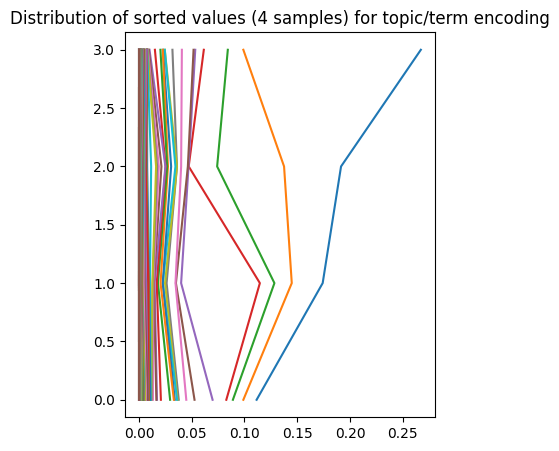

In [37]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,5))

sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])

plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [38]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

#perplexity_val = 10 # 大き過ぎると良くない
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

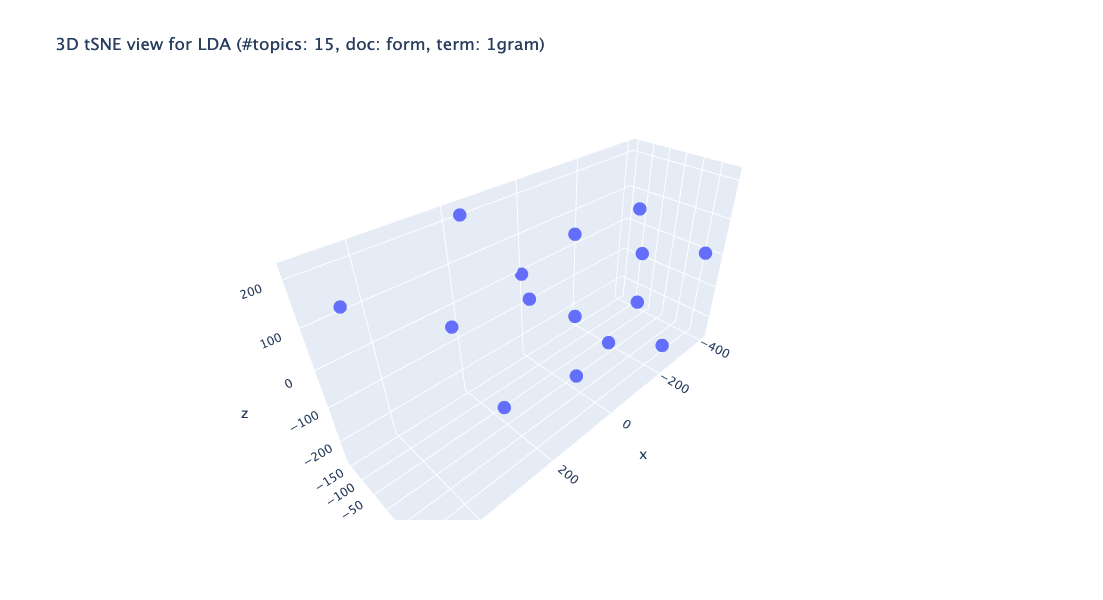

In [39]:
## Plotlyを使って tSNE の結果の可視化 (3D)

#import plotly.express as pex
import plotly.graph_objects as go
import numpy as np

top_tSNE = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(x = top_tSNE[:,0], y = top_tSNE[:,1], z = top_tSNE[:,2],
                                     mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"3D tSNE view for LDA (#topics: {n_topics}, doc: {doc_type}, term: {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

In [40]:
## 構築した LDA モデルを使って文(書)を分類する

## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター

ntopics = n_topics # LDA の構築の最に指定した値を使う

check      = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

5876

In [41]:
## enc 列の追加

#df['enc'] = np.array(encoding) # This flattens arrays
#df['enc'] = list(encoding) # ineffective
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

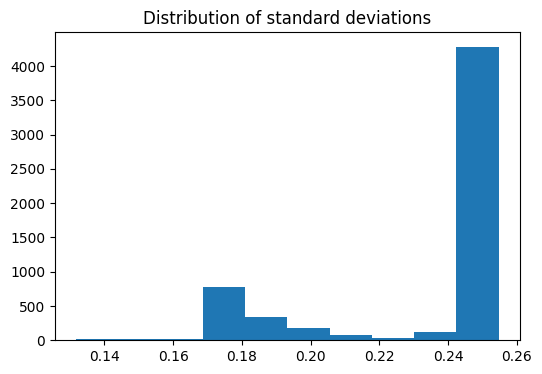

In [42]:
## エンコーディングのstd の分布を見る

from scipy.stats import tstd
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))

std_data = [ tstd(x) for x in df['enc'] ]
plt.hist(std_data)

plt.title("Distribution of standard deviations")
plt.show()

In [43]:
## doc のエンコーディング

## 一様分布の事例を除外

from scipy.stats import tstd # standard deviation の計算用

print(f"{len(df)} instances before filtering")

check = False

doc_enc = df['enc']
max_std = max([ tstd(x) for x in doc_enc])
if check: print(f"std max: {max_std}")

min_std = min([ tstd(x) for x in doc_enc])
if check: print(f"std min: {min_std}")

first_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

5876 instances before filtering
std 1st min: 0.13171132964573745
std 2nd min: 0.25472534055128543


In [44]:
## df_filtered の定義

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if tstd(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"{len(df_filtered)} instances after filtering ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.06368133513782136
5876 instances after filtering (0 instances removed)


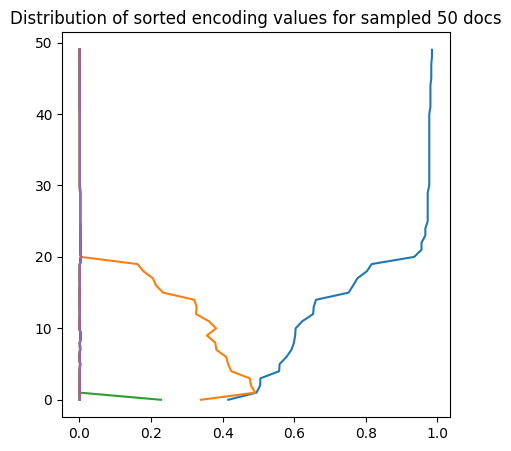

In [45]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])

plt.figure(figsize = (5,5))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [46]:
len(df_filtered['language'])

5876

In [47]:
df_filtered['language'].value_counts

<bound method IndexOpsMixin.value_counts of 665     chinese
109      arabic
785      french
526    japanese
218     spanish
         ...   
752     spanish
455    japanese
680     chinese
809    japanese
105      korean
Name: language, Length: 5876, dtype: object>

In [48]:
## tSNE 用の事例サンプリング = tSNE_df の定義

tSNE_sampling = True
tSNE_sampling_rate = 0.33
if tSNE_sampling:
    tSNE_df_original = df_filtered.copy()
    sample_n = round(len(tSNE_df_original) * tSNE_sampling_rate)
    tSNE_df = tSNE_df_original.sample(sample_n)
    print(f"tSNE_df has {len(tSNE_df)} rows after sampling")
else:
    tSNE_df = df_filtered

tSNE_df has 1939 rows after sampling


In [49]:
tSNE_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'bengali', 'chinese',
       'english', 'esperanto', 'finnish', 'french', 'greek', 'galician',
       'german', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian',
       'japanese', 'korean', 'russian', 'spanish', 'swahili', 'turkish',
       'language', 'size', '1gram', '2gram', '3gram', 'skippy2gram',
       'skippy3gram', 'enc'],
      dtype='object')

In [50]:
tSNE_df['language'].value_counts

<bound method IndexOpsMixin.value_counts of 184     spanish
739    japanese
612      arabic
68     japanese
19       french
         ...   
825     swahili
340      arabic
283      korean
418      korean
115     spanish
Name: language, Length: 1939, dtype: object>

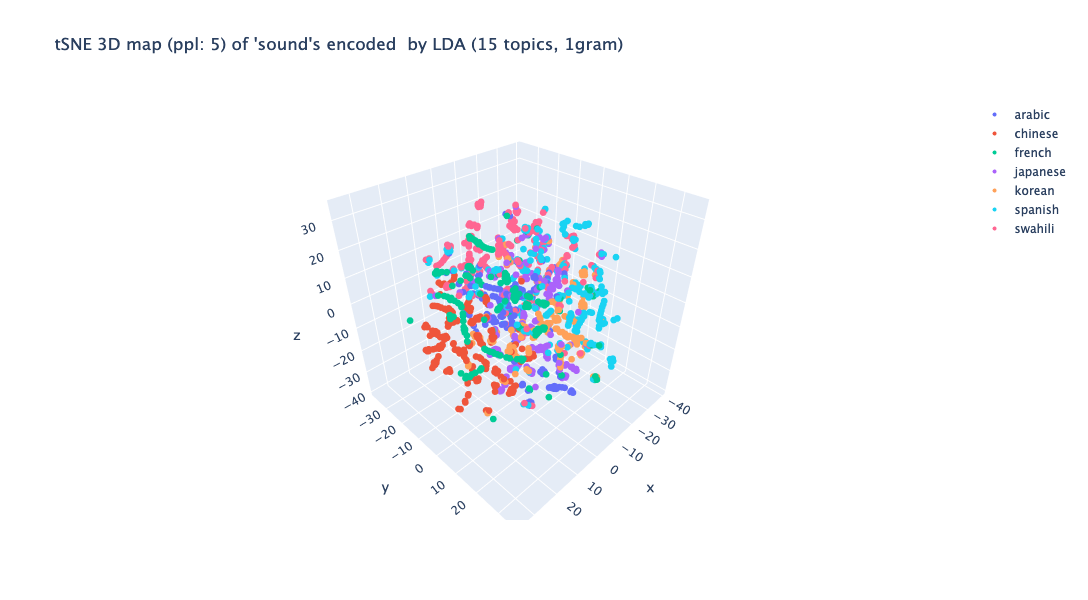

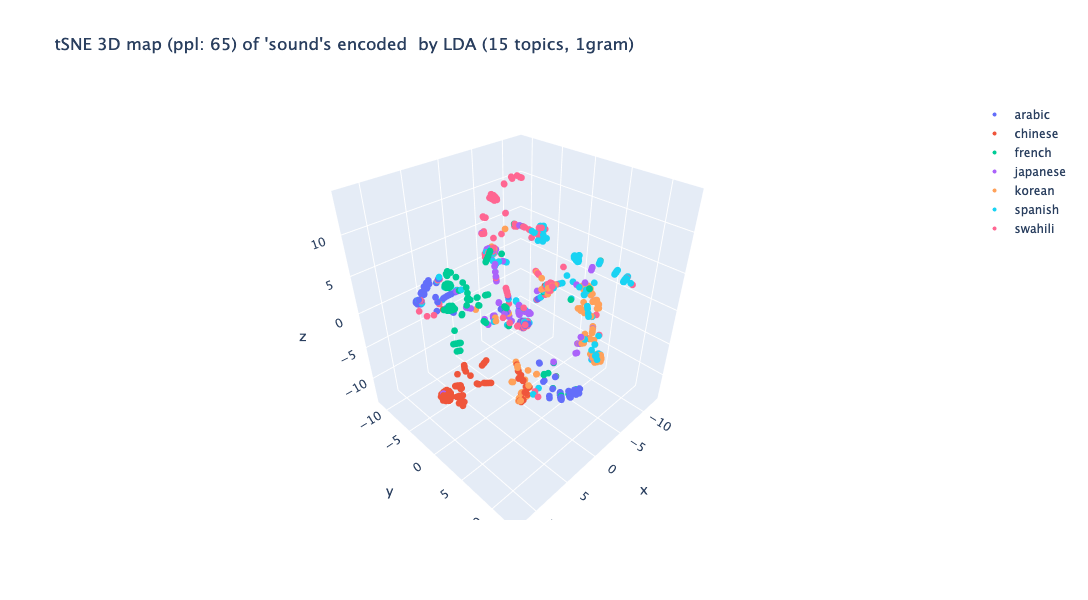

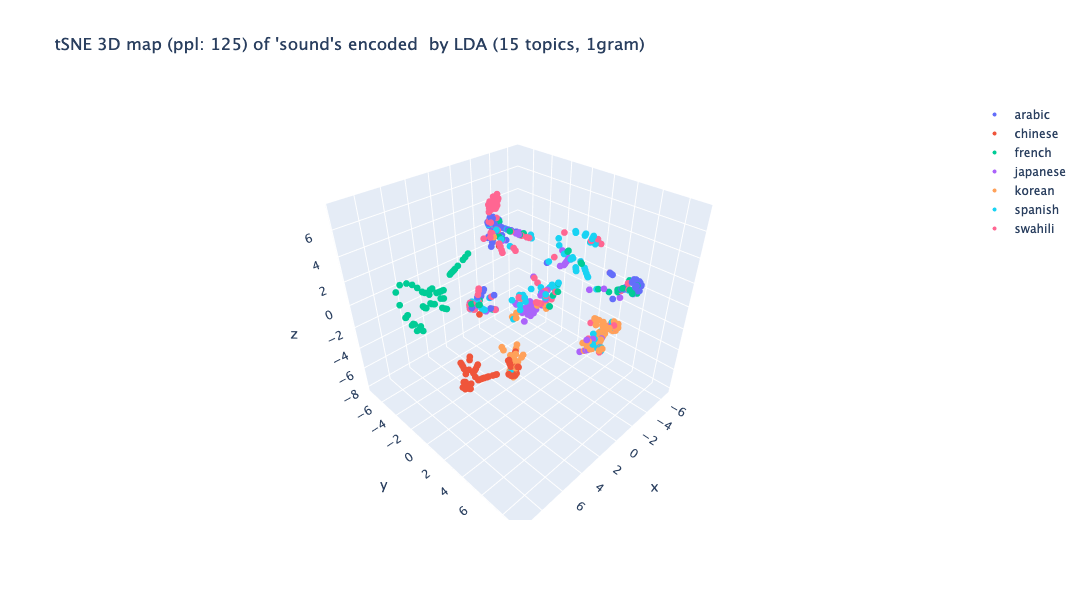

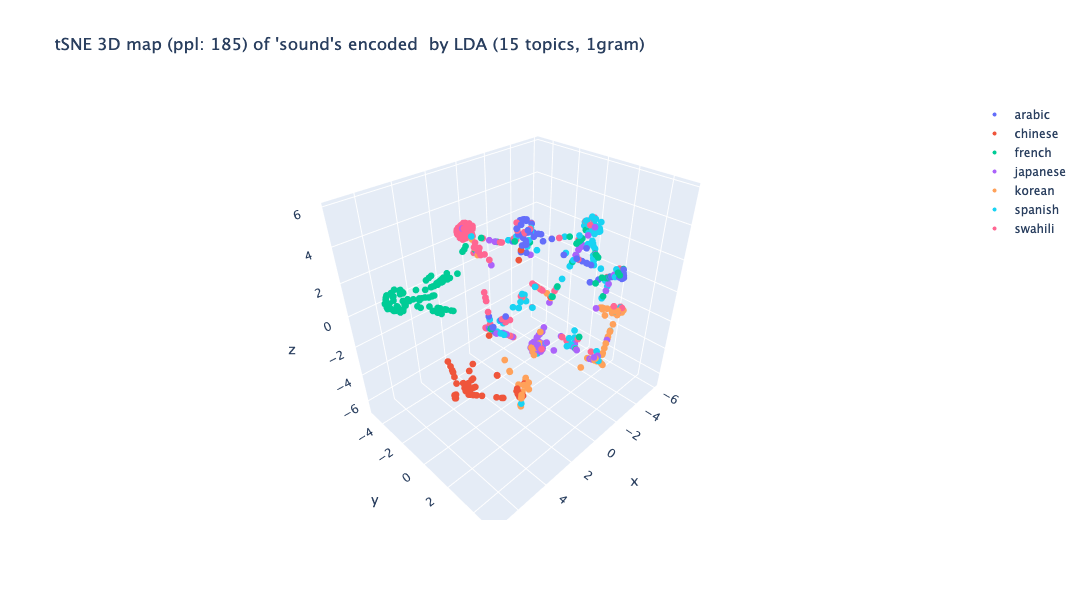

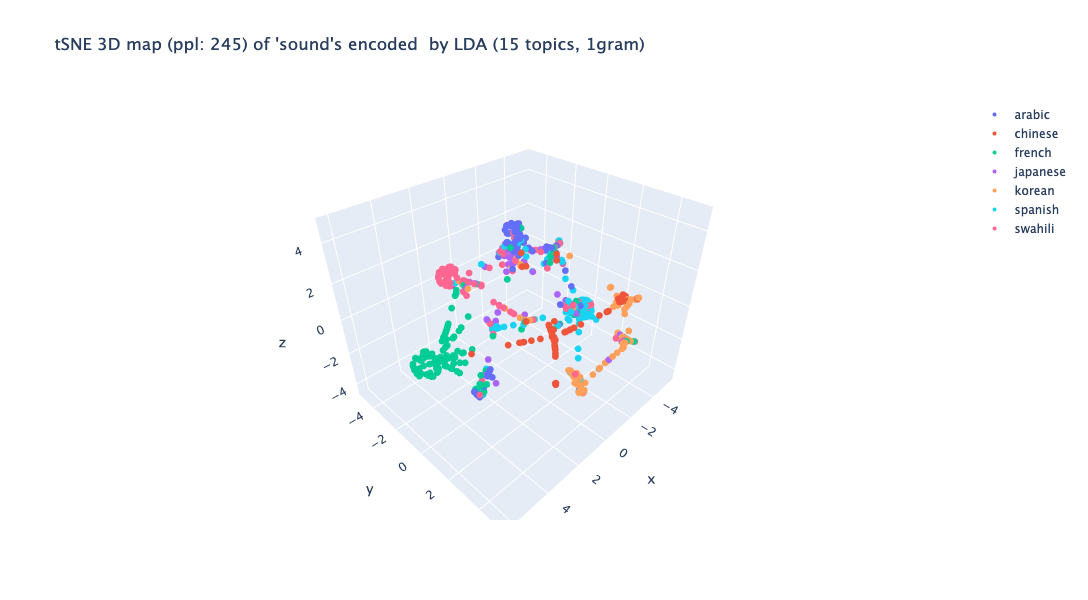

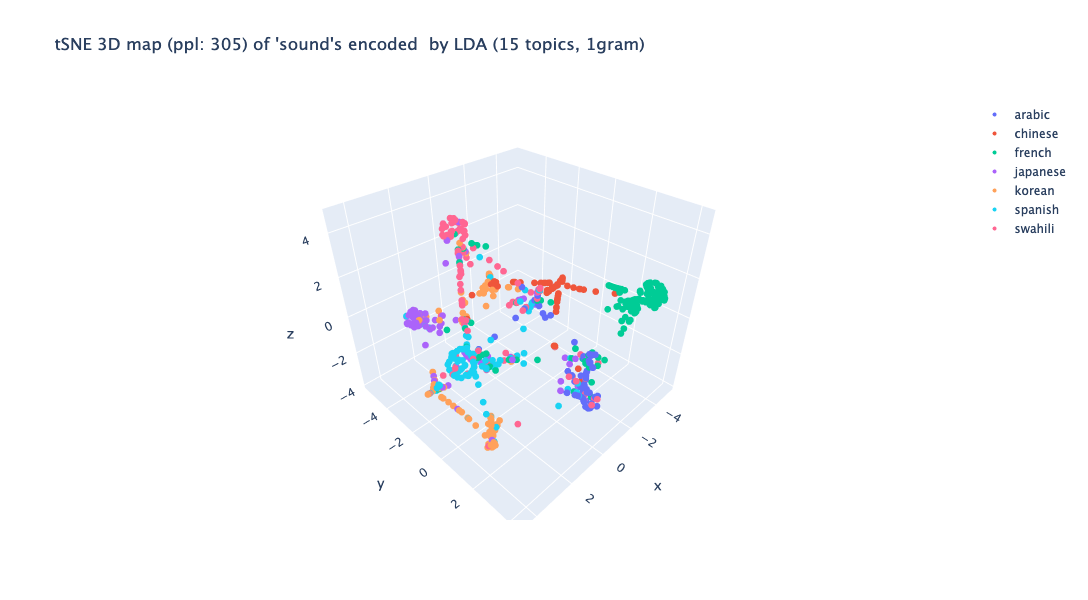

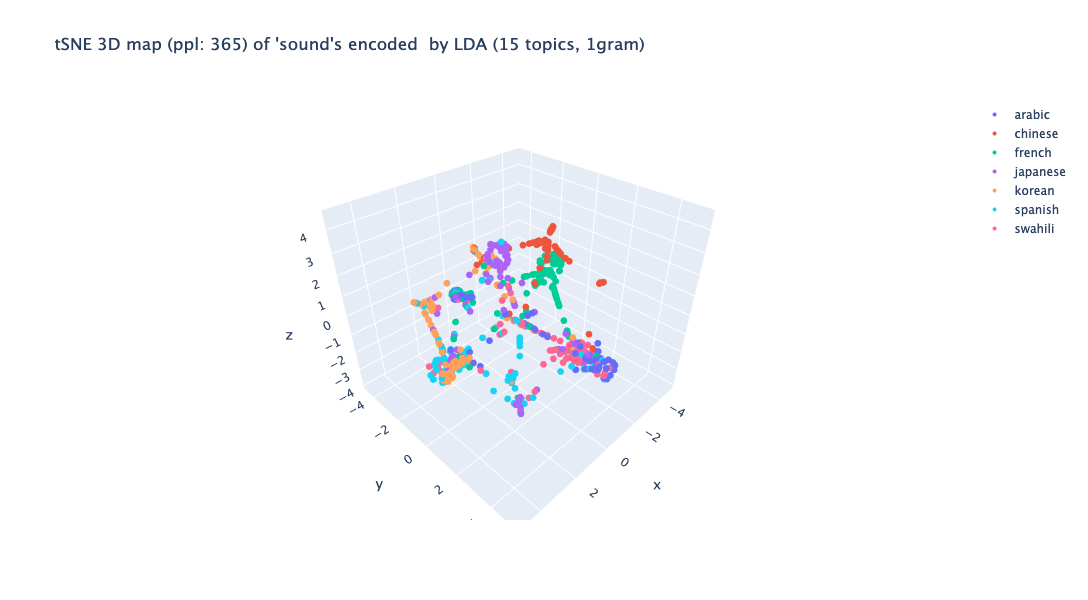

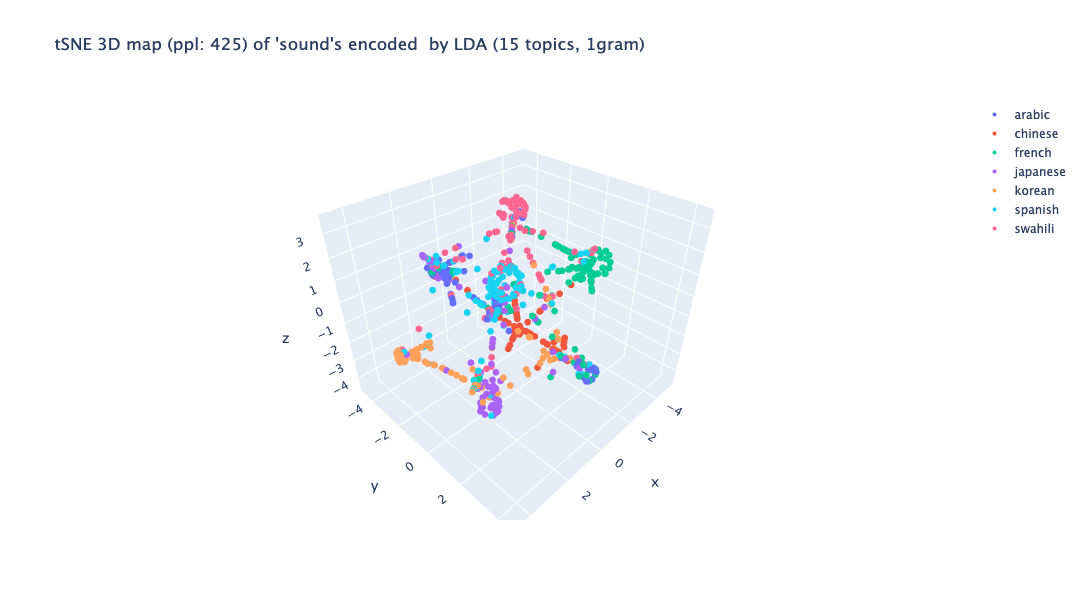

In [51]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定

perplexity_max_val = round(len(tSNE_df)/4)

for perplexity_val in range(5, perplexity_max_val, 60):
    
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(tSNE_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            tSNE_df['language']) # zip(..)が必要
    df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

    ## 作図
    fig = go.Figure()
    for lang in np.unique(df['language']):
        part = df[df['language'] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 4),
                showlegend = True
            )
        )

    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of '{doc_attr}'s encoded\n by LDA ({n_topics} topics, {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600,)
    fig.show()

In [52]:
## 階層クラスタリングのための事例のサンプリング

hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
df_size = len(tSNE_df)
hc_sample_n = round(df_size * hc_sampling_rate)
hc_df = tSNE_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
hc_df['language'].value_counts()

194 rows are sampled


language
french      44
swahili     30
korean      30
arabic      29
spanish     25
chinese     18
japanese    18
Name: count, dtype: int64

In [53]:
## 日本語表示のための設定
#import matplotlib.pyplot as plt
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

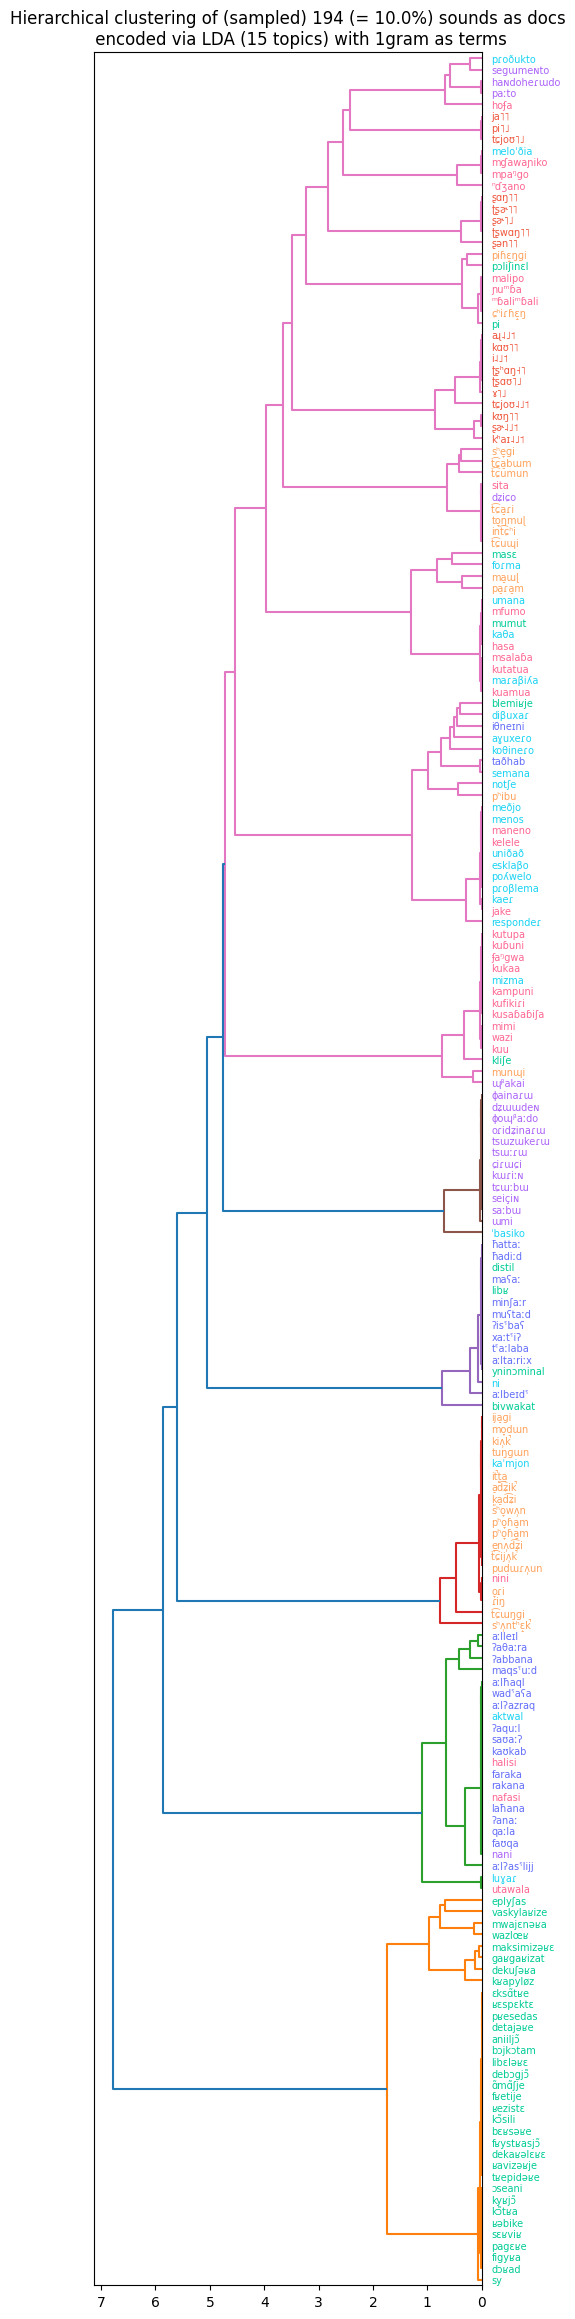

In [54]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
Enc = list(hc_df['enc'])
linkage = linkage(Enc, method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (5, round(len(hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(hc_df['language'])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = hc_df.loc[hc_df[doc_type] == form]
    #lang = row['language']
    lang = row['language'].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(plotly.colors.qualitative.Plotly[lang_id]) # id の基数調整
#
plt.show()

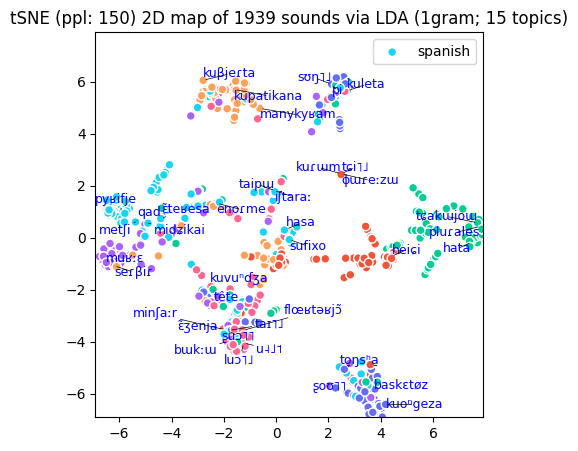

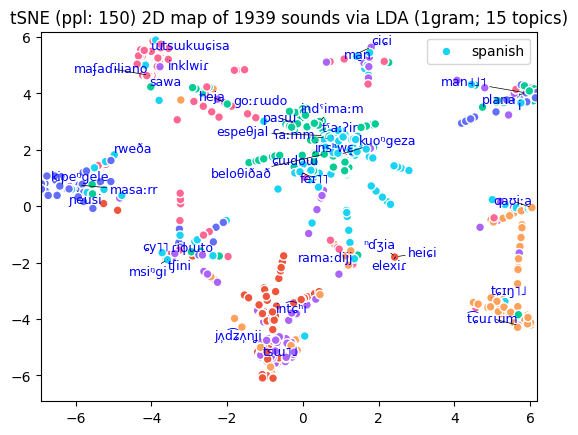

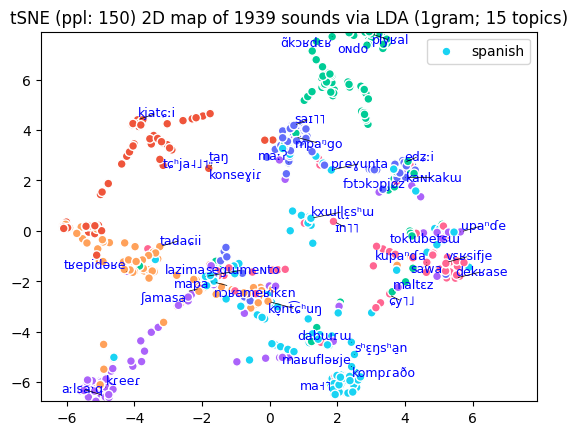

In [55]:
## tSNE の結果の可視化 (2D)

#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## tSNE 事例の生成
perplexity_selected = 150
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(tSNE_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

T = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2],
        tSNE_df['language']) # zip(..)が必要
df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

## 描画
## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
    
for roll in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
    if check:
        print(r)
    X, Y = df.iloc[:,roll[0]], df.iloc[:,roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    colormap = pex.colors.qualitative.Plotly
    lang_list = list(np.unique(tSNE_df['language']))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df['language'] ]
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    lab_sampling_rate = 0.02
    lab_sample_n = round(len(tSNE_df) * lab_sampling_rate)
    sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(tSNE_df[doc_type]), lab_sample_n) ]

    ## labels の生成
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 9, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts, force_points = 0.2, force_text = 0.2,
                expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #

    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(tSNE_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(cmapped)
    plt.legend(df['language'])
    plt.show()